In [1]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from PIL import Image
import sys
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from molmo_utils import load_model, do_inference, get_coordinates, calculate_probability_of_coordinates
from utils import extract_all, plot_scatter, calculate_normalized_euclidian_distance, visualize_points_on_image, calculate_spread, calculate_all_clusters, show_all_clusters

2025-03-09 15:00:54.208704: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 15:00:55.072998: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-09 15:00:55.073041: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-09 15:00:55.073070: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-09 15:00:55.527672: I tensorflow/core/platform/cpu_feature_g

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
def create_vqa_prompt(coordinates, task, width, height):
    prompt_start = "You are an expert in deciding which coordinates are the most relevant ones for this specific task: "
    prompt_middle = f". There are {len(coordinates)} different coordinates from which you have to choose the most relevant one to succeed in the task. The width of the image is {width} pixels and the height of the image is {height} pixels. The coordinates from which you have to choose are: "
    prompt_end = " Output only the coordinates that you decide on in the form of (x, y) with x and y beeing the coordinates. Do not output anything else!"
    return prompt_start + task + prompt_middle + str(coordinates) + prompt_end

def do_vqa(coordinates, task, image_path, temperature):
    with Image.open(image_path) as image:
        width = image.width
        height = image.height
        prompt = create_vqa_prompt(coordinates, task, width, height)
        output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)
    return output_text
    

Output for task: pick up vegetable and put it on the table.
with coordinates : [(280, 270), (450, 350), (200, 215)]:
 (280, 270)


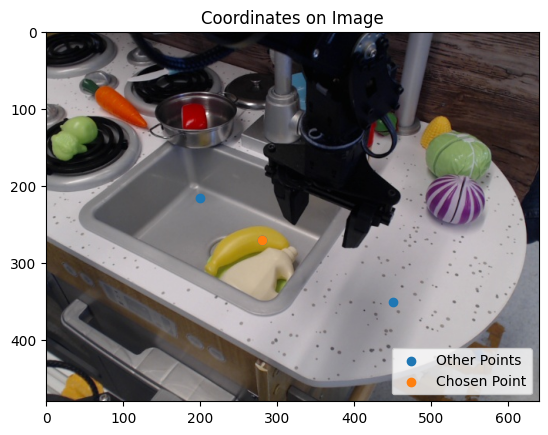

Output for task: pick up the can and put it next to the tomato.
with coordinates : [(130, 250), (500, 300), (300, 350)]:
 (500, 300)


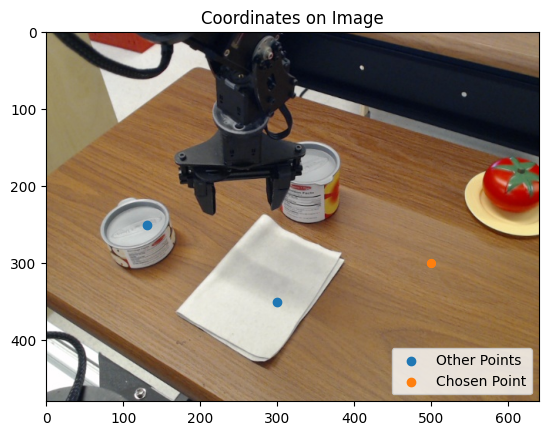

In [30]:
#task8 - can - (130,250) (380, 200) / (500, 300) (300, 350)
#task2 - vegetable (280, 270) (110, 90) (550, 200) / (205, 100) (450, 350) (200, 215)

tasks, images, groundtruths, objects_list = extract_all("../data/uncertain_experiments")
for i in range(len(tasks)):
    task = tasks[i]
    image_path = images[i]
    if("task2" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215)]
        output = do_vqa(coordinates, task, image_path, 0.2)
        print(f"Output for task: {task}")
        print(f"with coordinates : {coordinates}:")
        print(output)
        output = output.strip()  # Remove extra whitespace
        output = output.strip("()")  # Remove surrounding parentheses
        x, y = map(int, output.split(","))  # Convert to integers
        output = (x, y) 
        with Image.open(image_path) as image:
            visualize_points_on_image(image, ["Other Points", "Chosen Point"], [coordinates, [output]])
    if ("task8" in image_path):
        coordinates = [(130, 250), (500, 300), (300, 350)]
        output = do_vqa(coordinates, task, image_path, 0.2)
        print(f"Output for task: {task}")
        print(f"with coordinates : {coordinates}:")
        print(output)
        output = output.strip()  # Remove extra whitespace
        output = output.strip("()")  # Remove surrounding parentheses
        x, y = map(int, output.split(","))  # Convert to integers
        output = (x, y) 
        with Image.open(image_path) as image:
            visualize_points_on_image(image, ["Other Points", "Chosen Point"], [coordinates, [output]])
    else:
        continue
    

In [60]:
import string
import torch
import matplotlib.pyplot as plt

def create_vqa_prompt(coordinates, task, object, width, height):
    choices = list(string.ascii_lowercase)
    choices_string = ", ".join(choices[:len(coordinates)])
    prompt_coordinates = ""
    for i in range(len(coordinates)):
        prompt_coordinates += f"{choices[i]}: {coordinates[i]}, "
    prompt_coordinates = prompt_coordinates[:-2]

    
    prompt_start = "You are shown a robotic setting. Your mission is to pick up the following object: "
    prompt_middle = f". You have to choose one out of {len(coordinates)} coordinates, to point to the object. The format of the possible answers looks like this: a: (x1, y1), b: (x2, y2), ... with (x1, y1) and (x2, y2) beeing the coordinates to choose from. The width of the image is {width} pixels and the height of the image is {height} pixels. The coordinates from which you have to choose are the following: "
    
    prompt_end = f". Your output should be the letter of the best answer out of the choices: {choices_string}. Do not use whitespace before or after the letter. Do not output anything else."
    return prompt_start + object + prompt_middle + prompt_coordinates + prompt_end

def get_top_probability_distribution(output_char, output_tokens, tokenizer, top_k=10):
    softmax_fn = torch.nn.Softmax(dim=-1)

    logits = output.logits
    generated_logits = torch.cat(logits, dim=0)
    generated_tokens = output.sequences[0, inputs['input_ids'].size(1):]
    
    answer_token = generated_tokens[0]
    answer_logits = generated_logits[0]
    
    probs = softmax_fn(answer_logits.squeeze(0))
    
    token_prob = probs[answer_token].item()
    
    top_probs, top_indices = torch.topk(probs, top_k)
    top_tokens = [(tokenizer.decode([idx]), top_probs[i].item()) for i, idx in enumerate(top_indices)]

    return token_prob, top_tokens

def do_vqa(coordinates, task, object, image_path, model, processor, temperature):
    with Image.open(image_path) as image:
        width = image.width
        height = image.height
        prompt = create_vqa_prompt(coordinates, task, object, width, height)
        #print(f"Prompt: {prompt}")
        output_text, output, inputs = do_inference(image, prompt, model, processor, temperature)
    return output_text, output, inputs

def visualize_vqa(image, tokens, probs, coordinates, title="VQA"):
    sorted_coordinates = sort_coordinates_by_letters(tokens, coordinates)

    plt.imshow(image, alpha=1)
    image_width, image_height = image.size

    for prob, token, coordinate in zip(probs, tokens, sorted_coordinates):
        # Extract and plot the points
        x_coords = [x for x, y in [coordinate]]
        y_coords = [y for x, y in [coordinate]]
        label = f"{prob:.4f} ({token})"
        plt.scatter(x_coords, y_coords, marker='o', label=label)
    
    # Add labels and show the plot
    plt.title(title)
    plt.legend(loc="lower right")
    plt.axis("on")  # Show axes
    plt.show()
    plt.close()

def sort_coordinates_by_letters(letters, coordinates):
    """
    Sorts the list of coordinates based on the order of the permuted letter list.
    
    :param letters: List of unique lowercase letters (permutation of 'a' to some letter).
    :param coordinates: List of coordinates corresponding to the letters.
    :return: Sorted list of coordinates based on the sorted order of letters.
    """
    letters = [letter.strip() for letter in letters]
    
    expected_letters = [chr(i) for i in range(ord('a'), ord('a') + len(coordinates))]
    if sorted(letters) != expected_letters:
        raise ValueError(f"The letters list must contain a contiguous sequence from 'a' to '{expected_letters[-1]}'")
        
    letter_to_index = {letter: i for i, letter in enumerate(expected_letters)}
    sorted_coordinates = [coordinates[letter_to_index[letter]] for letter in letters]
    return sorted_coordinates

Task: pick up fruit and put it on the table.
 b: 0.5148
 a: 0.2485
 c: 0.2298
 d: 0.0010
 B: 0.0006
 The: 0.0003
 A: 0.0003
 letter: 0.0003
 C: 0.0002
b: 0.0002


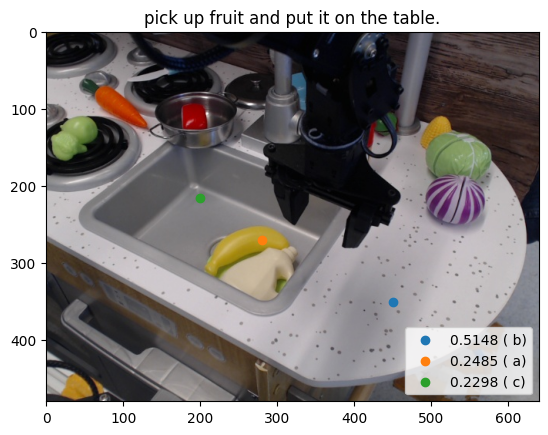

Task: pick up glass cup
 c: 0.3276
 b: 0.2597
 d: 0.2217
 a: 0.1848
 D: 0.0005
 C: 0.0004
 B: 0.0003
 The: 0.0003
 letter: 0.0003
 A: 0.0001


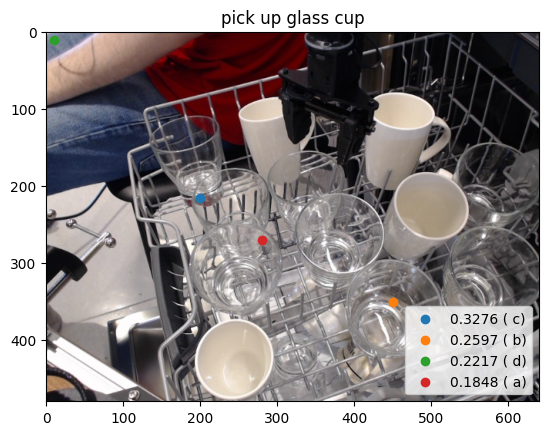

Task: Move the can from the top left of the burner to the bottom left of the burner
 c: 0.3061
 d: 0.2615
 a: 0.2544
 b: 0.1731
 D: 0.0004
 C: 0.0003
 The: 0.0003
 B: 0.0002
 letter: 0.0002
 A: 0.0002


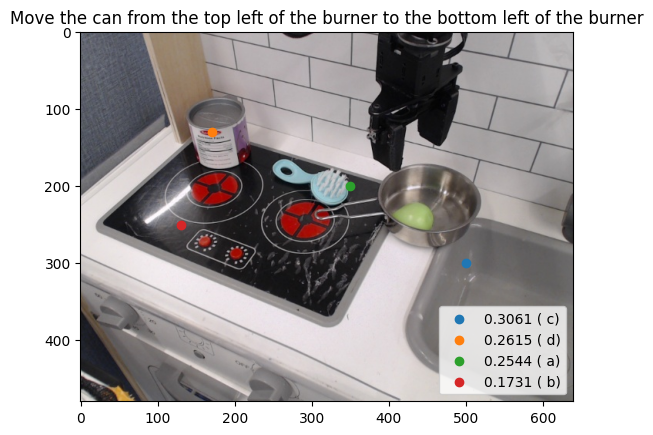

Task: pick up the can and put it next to the tomato
 c: 0.3698
 a: 0.2437
 d: 0.1934
 b: 0.1874
 C: 0.0004
 D: 0.0004
 B: 0.0003
 The: 0.0003
 A: 0.0002
 letter: 0.0002


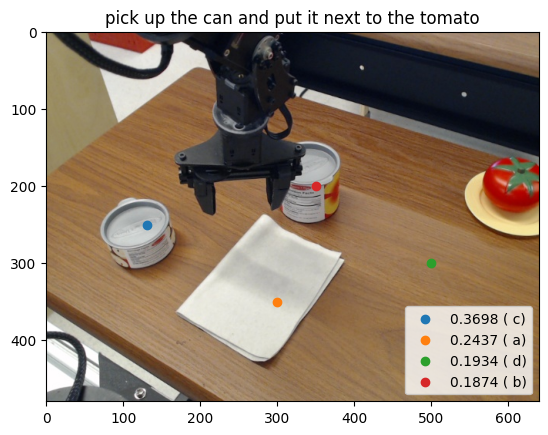

In [61]:
#task8 - can - (130,250) (380, 200) / (500, 300) (300, 350)
#task2 - vegetable (280, 270) (110, 90) (550, 200) / (205, 100) (450, 350) (200, 215)

tasks, images, groundtruths, objects_list = extract_all("../data/uncertain_experiments")
for i in range(len(tasks)):
    task = tasks[i]
    object = objects_list[i][0]
    image_path = images[i]
    
    if("task10" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215), (10, 10)]
    elif("task2" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215)]
    elif("task8" in image_path):
        coordinates = [(300, 350), (350, 200), (130, 250), (500, 300)]
    elif("bridge_2_can" in image_path):
        coordinates = [(350, 200), (130, 250), (500, 300), (170, 130)]
    else:
        #coordinates = [(300, 350), (350, 200), (130, 250), (500, 300)]
        continue

    print(f"Task: {task}")
    
    output_text, output, inputs = do_vqa(coordinates, task, object, image_path, model, processor, 0.2)
    
    token_prob, top_tokens= get_top_probability_distribution(output_text, output, processor.tokenizer)
    for token, prob in top_tokens:
        print(f"{token}: {prob:.4f}")
    
    with Image.open(image_path) as image:  
        tokens, probs = zip(*top_tokens[:len(coordinates)])
        visualize_vqa(image, tokens, probs, coordinates, title=task)


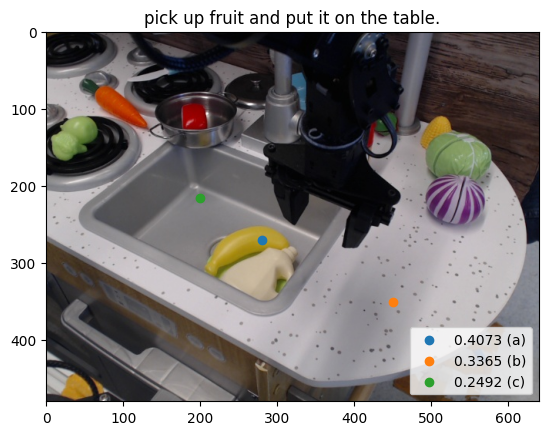

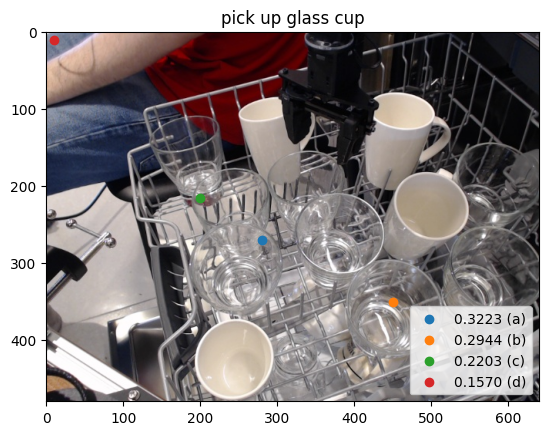

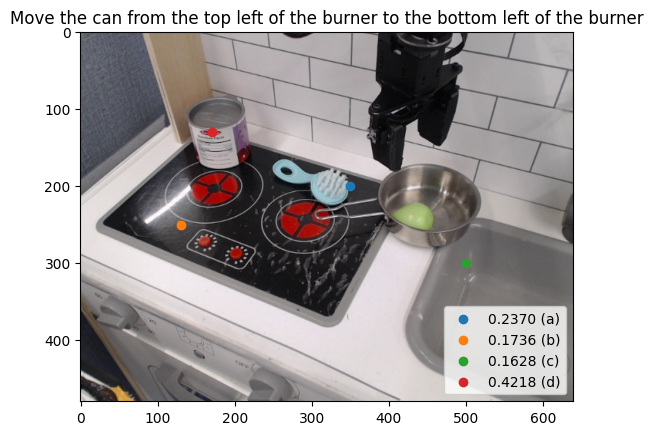

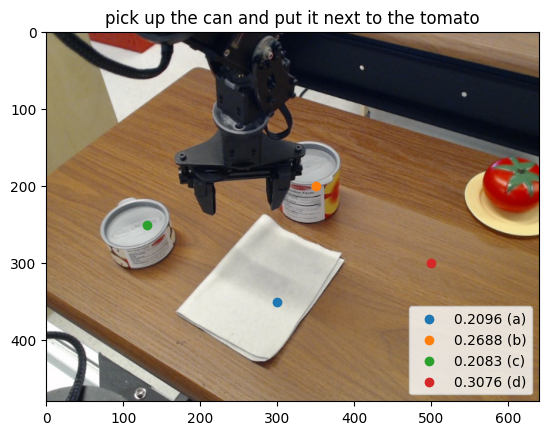

In [62]:
import random
RUNS = 10
tasks, images, groundtruths, objects_list = extract_all("../data/uncertain_experiments")
for i in range(len(tasks)):
    task = tasks[i]
    image_path = images[i]
    object = objects_list[i][0]
    if("task10" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215), (10, 10)]
    elif("task2" in image_path):
        coordinates = [(280, 270), (450, 350), (200, 215)]
    elif("task8" in image_path):
        coordinates = [(300, 350), (350, 200), (130, 250), (500, 300)]
    elif("bridge_2_can" in image_path):
        coordinates = [(350, 200), (130, 250), (500, 300), (170, 130)]
    else:
        #coordinates = [(300, 350), (350, 200), (130, 250), (500, 300)]
        continue
    summed_probs = {coord: 0 for coord in coordinates}
    for i in range(RUNS):
        shuffled = random.sample(coordinates, len(coordinates))
        
        output_text, output, inputs = do_vqa(shuffled, task, object, image_path, model, processor, 0.2)
        
        token_prob, top_tokens= get_top_probability_distribution(output_text, output, processor.tokenizer, len(coordinates))
        for token, prob in top_tokens:
            #print(f"{token}: {prob:.4f}")
            summed_probs[shuffled[ord(token.strip()) - ord('a')]] += prob
            
    average_probs = [ prob / RUNS for coord, prob in summed_probs.items() ]
    with Image.open(image_path) as image:
        visualize_vqa(image, list(string.ascii_lowercase[:len(coordinates)]), average_probs, coordinates, title=task)